### **Goal FLow**
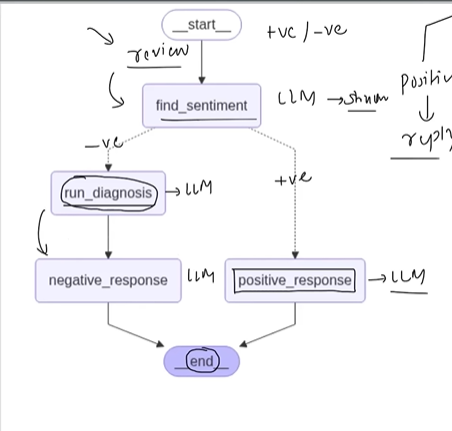

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
import dotenv
dotenv.load_dotenv()
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

c:\Codes\Learning\Lang_graph\venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from pydantic import BaseModel, Field

In [3]:
class SentimentState(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="The sentiment of the review")
    

In [4]:
structured_model = model.with_structured_output(SentimentState)

In [21]:
text = """I absolutely love this product! It has changed my life for the better and I can't imagine living without it now."""

structured_model.invoke(text)

SentimentState(sentiment='positive')

In [5]:
class ReviewState(TypedDict):
    review: str
    sentiment : Literal["positive", "negative"]
    diagnosis: str
    response: str

In [6]:
class DiagnosisSchema(BaseModel):
  issuetype: Literal["UX", "Performance", "Bug", "Feature_request","Support", "Other"] = Field(description="The type of issue identified in the review")
  tone: Literal["Angry", "Disappointed", "Frustrated", "Neutral"] = Field(description="The emotional tone of the review")
  urgency: Literal["Low", "Medium", "High", "Critical"] = Field(description="The urgency level of addressing the issue in the review")

In [7]:
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [8]:
def find_sentiment(state: ReviewState) :
    prompt = f"""Determine the sentiment of the following review as either "positive" or "negative".\n {state['review']}"""

    sentiment = structured_model.invoke(prompt)
    return {"sentiment": sentiment}

In [9]:
def positive_response(state: ReviewState):
  prompt = f"""Generate a positive response and warm thank you with the user to leave feedback on our website to the following review:\n {state['review']}"""

  response = model.invoke(prompt)
  return {"response": response}

In [10]:
def run_diagnosis(state: ReviewState):

  prompt = f"""Analyze the following negative review and provide a structured diagnosis including issue type, tone, and urgency:\n {state['review']}"""

  diagnosis = structured_model2.invoke(prompt)
  return {"diagnosis": diagnosis.model_dump()}

In [11]:
def negative_response(state: ReviewState):

  dignosis = state['diagnosis']

  prompt = f"""The user had a {dignosis['issuetype']} issue and expressed a {dignosis['tone']} tone in their review. Generate a professional and empathetic response addressing their concerns and offering assistance to resolve the issue promptly.\n {state['review']}"""

  response = model.invoke(prompt).content
  return {"response": response}

In [12]:
def check_sentiment(state: ReviewState) -> Literal["positive_response", "run_diagnosis"]:
    if state['sentiment'] == "positive":
        return "positive_response"
    else:
        return "run_diagnosis"


In [13]:
graph1 = StateGraph(ReviewState)

graph1.add_node("find_sentiment", find_sentiment)
graph1.add_node("positive_response", positive_response)
graph1.add_node("run_diagnosis", run_diagnosis)
graph1.add_node("negative_response", negative_response)



graph1.add_edge(START, "find_sentiment")
graph1.add_conditional_edges("find_sentiment", check_sentiment)

graph1.add_edge("positive_response", END)


graph1.add_edge("run_diagnosis", "negative_response")
graph1.add_edge("find_sentiment", END)
workflow1 = graph1.compile()

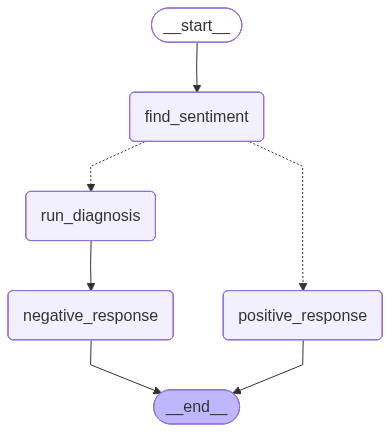

In [14]:
workflow1

In [15]:
positive_review = """I absolutely love this product! It has changed my life for the better and I can't imagine living without it now."""
negative_review = """I am extremely disappointed with this service. It has been nothing but a series of frustrating experiences, and I feel let down by the lack of support and responsiveness."""

In [16]:
initial_state = {
  'review': negative_review,
}

res = workflow1.invoke(initial_state)

print(res)

{'review': 'I am extremely disappointed with this service. It has been nothing but a series of frustrating experiences, and I feel let down by the lack of support and responsiveness.', 'sentiment': SentimentState(sentiment='negative'), 'diagnosis': {'issuetype': 'Support', 'tone': 'Disappointed', 'urgency': 'High'}, 'response': "Subject: Regarding your recent experience and how we can help\n\nDear [User Name],\n\nThank you for taking the time to share your feedback. We sincerely apologize that your experience with our service has been frustrating and disappointing. We understand your frustration, and we're truly sorry that you feel let down by our lack of support and responsiveness.\n\nWe value your business and are committed to resolving this issue for you as quickly as possible. To help us understand the specifics of your situation and provide the most effective assistance, could you please provide us with more details about the issues you've encountered? This might include:\n\n*   *

In [18]:
from IPython.display import display, Markdown

display(Markdown(res['response']))

Subject: Regarding your recent experience and how we can help

Dear [User Name],

Thank you for taking the time to share your feedback. We sincerely apologize that your experience with our service has been frustrating and disappointing. We understand your frustration, and we're truly sorry that you feel let down by our lack of support and responsiveness.

We value your business and are committed to resolving this issue for you as quickly as possible. To help us understand the specifics of your situation and provide the most effective assistance, could you please provide us with more details about the issues you've encountered? This might include:

*   **The specific service or feature you're referring to.**
*   **Dates and times of your interactions with our support team (if applicable).**
*   **A detailed description of the problems you experienced.**
*   **Any ticket or reference numbers related to your support requests.**

You can reply directly to this email with the information, or if you prefer, you can call us at [Phone Number] during our business hours [Business Hours] and speak with a member of our team.

We are committed to turning your experience around. We believe in our service and the value it provides, and we want to demonstrate that to you. We will investigate your concerns thoroughly and work diligently to find a solution that meets your needs.

Thank you for your patience and understanding. We look forward to hearing from you and working towards a resolution.

Sincerely,

The [Your Company Name] Support Team